In [ ]:
# AcousticTB: TB Screening from Cough Analysis
'''
This notebook guides you through the entire pipeline:
1. Data augmentation (clean + noisy mel-spectrograms)  
2. Train a light CNN encoder and extract embeddings  
3. Train tuned XGBoost on embeddings  
4. Train an MLP head for final stacking  
5. Evaluation and plots
'''

#The code omits the full RandomizedSearchCV—parameters pre-set to your best.

In [ ]:
from pathlib import Path
BASE_DIR = Path().resolve()
RAW_AUDIO_DIR = BASE_DIR/"data"/"raw"/"solicited_coughs"/"audio"
META_DIR = BASE_DIR/"data"/"raw"/"solicited_coughs"/"metadata"
PROCESSED_DIR = BASE_DIR/"data"/"processed"
FEAT_DIR = PROCESSED_DIR/"features"

print(f"BASE_DIR = {BASE_DIR}")
print(f"Found {len(list(RAW_AUDIO_DIR.glob('*.wav')))} .wav files")

BASE_DIR = C:\Users\Saatvik\.vscode\AcousticTB
Found 9772 .wav files


In [ ]:
%run src/data_agumentation.py

Loading ESC-50 environmental sounds...
Loaded 800 ESC-50 environmental sounds
Loaded 800 ESC-50 environmental sounds


Processing audio files: 100%|██████████████████████████████████████████████████████| 9772/9772 [02:31<00:00, 64.40it/s]


Created 29316 feature files
Unique patients: 9772
File count breakdown:
noise_type
clean            9772
environmental    9772
gaussian         9772
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from collections import Counter
BASE_DIR=Path().resolve()
src_dir=BASE_DIR/"src"
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [57]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

def composite(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return 0.56 * sensitivity + 0.44 * specificity

def load_all_from_processed_clean(noisy_csv: str):
    df = pd.read_csv(noisy_csv)
    
    # load correct metadata file with TB labels
    meta_dir = Path(noisy_csv).parent.parent / "raw" / "solicited_coughs" / "metadata"
    meta_path = meta_dir / "CODA_TB_additional_variables_train.csv"
    
    if meta_path.exists():
        meta_df = pd.read_csv(meta_path)
    else:
        meta_df = None
    
    spectrograms = []
    labels = []
    clinical_data = []
    noise_types = []
    base_patient_ids = []
    
    for i, row in df.iterrows():
        feat_path = Path(noisy_csv).parent / "features" / row['feature_file']
        if feat_path.exists():
            spec = np.load(feat_path)
            spectrograms.append(spec)
            
            tb_status = 0
            if meta_df is not None:
                participant_matches = meta_df[meta_df['participant'] == row['participant']]
                if not participant_matches.empty:
                    participant_row = participant_matches.iloc[0]
                    if 'Microbiologicreferencestandard' in participant_row:
                        tb_status = 1 if str(participant_row['Microbiologicreferencestandard']).upper() == 'POSITIVE' else 0
                    elif 'Sputumxpertreferencestandard' in participant_row:
                        tb_status = 1 if str(participant_row['Sputumxpertreferencestandard']).upper() == 'POSITIVE' else 0
            
            labels.append(tb_status)
            noise_types.append(row['noise_type'])
            base_patient_ids.append(row['base_patient_id'])
            
            clinical_features = [0.0] * 7
            if meta_df is not None:
                participant_matches = meta_df[meta_df['participant'] == row['participant']]
                if not participant_matches.empty:
                    participant_row = participant_matches.iloc[0]
                    clinical_features = [
                        float(participant_row.get('age', 0)) if pd.notna(participant_row.get('age', 0)) else 0.0,
                        float(participant_row.get('height', 0)) if pd.notna(participant_row.get('height', 0)) else 0.0,
                        float(participant_row.get('weight', 0)) if pd.notna(participant_row.get('weight', 0)) else 0.0,
                        float(participant_row.get('reported_cough_dur', 0)) if pd.notna(participant_row.get('reported_cough_dur', 0)) else 0.0,
                        float(participant_row.get('heart_rate', 0)) if pd.notna(participant_row.get('heart_rate', 0)) else 0.0,
                        float(participant_row.get('temperature', 0)) if pd.notna(participant_row.get('temperature', 0)) else 0.0,
                        float(row.get('sound_prediction_score', 0)) if pd.notna(row.get('sound_prediction_score', 0)) else 0.0
                    ]
            clinical_data.append(clinical_features)
    
    X_spec = np.array(spectrograms)
    y = np.array(labels)
    X_clin = np.array(clinical_data)
    
    return X_spec, y, X_clin, noise_types, base_patient_ids

In [58]:
noisy_csv = BASE_DIR/"data"/"processed"/"solicited_metadata_with_noise.csv"
X_spec, y, Xclin, noise_types, groups = load_all_from_processed_clean(str(noisy_csv))

print(f"Loaded x_spec shape: {X_spec.shape} and labels={len(y)}")
print(f"Noise distribution: {Counter(noise_types)}")

Loaded x_spec shape: (29316, 64, 64) and labels=29316
Noise distribution: Counter({'clean': 9772, 'environmental': 9772, 'gaussian': 9772})


In [29]:
import glob
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit

n, h, w = X_spec.shape
X_flat = X_spec.reshape(n, h * w)
X_all = np.hstack([X_flat, Xclin])

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(X_all, y, groups=groups))

X_tr = X_all[train_idx]
y_tr = y[train_idx]
X_val = X_all[val_idx]
y_val = y[val_idx]
Xclin_tr = Xclin[train_idx]
Xclin_val = Xclin[val_idx]

train_patients = set([groups[i] for i in train_idx])
val_patients = set([groups[i] for i in val_idx])
overlap = train_patients & val_patients

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

def focal_loss(gamma=1.5, alpha=0.6):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        logit_p_t = tf.math.log(p_t)
        loss = -alpha_t * tf.math.pow((1 - p_t), gamma) * logit_p_t
        return tf.reduce_mean(loss)
    return focal_loss_fixed

X_cnn = X_spec.reshape(-1, h, w, 1)
X_cnn_tr = X_cnn[train_idx]
X_cnn_val = X_cnn[val_idx]

print(f"training samples: tb+ {sum(y_tr)} ({100*sum(y_tr)/len(y_tr):.1f}%), tb- {len(y_tr)-sum(y_tr)} ({100*(len(y_tr)-sum(y_tr))/len(y_tr):.1f}%)")

# build the model
inputs = Input(shape=(h, w, 1))
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)  
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x)  
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
embedding = layers.Dense(256, activation='relu', name='embedding')(x)
x = layers.Dropout(0.3)(embedding)
outputs = layers.Dense(1, activation='sigmoid')(x)

cnn = Model(inputs=inputs, outputs=outputs)
embed_model = Model(inputs=inputs, outputs=embedding)

# using standard binary crossentropy, no class weights
cnn.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss=focal_loss(gamma=2.0, alpha=0.7),
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

# callbacks focused on auc
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=25,  
        restore_best_weights=True,
        mode='max',
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        patience=12, 
        factor=0.5,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

print(f"train: {len(X_cnn_tr)}, val: {len(X_cnn_val)}")

# train without class weights - let model learn naturally
history = cnn.fit(
    X_cnn_tr, y_tr, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_cnn_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("training done")

# evaluate on validation set
cnn_proba = cnn.predict(X_cnn_val).flatten()
cnn_auc = roc_auc_score(y_val, cnn_proba)

print(f"cnn auc: {cnn_auc:.4f}")

# find best threshold for balanced performance
thresholds = np.arange(0.05, 0.95, 0.01)
best_threshold = 0.5
best_score = 0

for thresh in thresholds:
    y_pred_t = (cnn_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # weighted score favoring sensitivity but considering all metrics
    score = 0.5 * sens + 0.3 * spec + 0.2 * acc
    
    if score > best_score:
        best_threshold = thresh
        best_sens = sens
        best_spec = spec
        best_acc = acc
        best_score = score

print(f"\nbest threshold: {best_threshold:.3f}")
print(f"sensitivity: {best_sens:.3f} ({best_sens*100:.1f}%)")
print(f"specificity: {best_spec:.3f} ({best_spec*100:.1f}%)")
print(f"accuracy: {best_acc:.3f} ({best_acc*100:.1f}%)")

cnn_pred_optimal = (cnn_proba >= best_threshold).astype(int)
final_acc = accuracy_score(y_val, cnn_pred_optimal)
print(f"final accuracy: {final_acc:.4f}")
print(f"final auc: {cnn_auc:.4f}")

X_cnn = X_spec.reshape(-1, h, w, 1)
X_cnn_tr = X_cnn[train_idx]
X_cnn_val = X_cnn[val_idx]

print(f"training samples: tb+ {sum(y_tr)} ({100*sum(y_tr)/len(y_tr):.1f}%), tb- {len(y_tr)-sum(y_tr)} ({100*(len(y_tr)-sum(y_tr))/len(y_tr):.1f}%)")

# build the model
inputs = Input(shape=(h, w, 1))
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)  
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x)  
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
embedding = layers.Dense(256, activation='relu', name='embedding')(x)
x = layers.Dropout(0.3)(embedding)
outputs = layers.Dense(1, activation='sigmoid')(x)

cnn = Model(inputs=inputs, outputs=outputs)
embed_model = Model(inputs=inputs, outputs=embedding)

# using standard binary crossentropy, no class weights
cnn.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='binary_crossentropy',
    # loss=focal_loss(gamma=1.5, alpha=0.6),  # could try this instead
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

# callbacks focused on auc
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=25,  
        restore_best_weights=True,
        mode='max',
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        patience=12, 
        factor=0.5,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

print(f"train: {len(X_cnn_tr)}, val: {len(X_cnn_val)}")

history = cnn.fit(
    X_cnn_tr, y_tr, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_cnn_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("training done")

# evaluate on validation set
cnn_proba = cnn.predict(X_cnn_val).flatten()
cnn_auc = roc_auc_score(y_val, cnn_proba)

print(f"cnn auc: {cnn_auc:.4f}")

# find best threshold for balanced performance
thresholds = np.arange(0.05, 0.95, 0.01)
best_threshold = 0.5
best_score = 0

for thresh in thresholds:
    y_pred_t = (cnn_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # weighted score favoring sensitivity but considering all metrics
    score = 0.5 * sens + 0.3 * spec + 0.2 * acc
    
    if score > best_score:
        best_threshold = thresh
        best_sens = sens
        best_spec = spec
        best_acc = acc
        best_score = score

print(f"\nbest threshold: {best_threshold:.3f}")
print(f"sensitivity: {best_sens:.3f} ({best_sens*100:.1f}%)")
print(f"specificity: {best_spec:.3f} ({best_spec*100:.1f}%)")
print(f"accuracy: {best_acc:.3f} ({best_acc*100:.1f}%)")

cnn_pred_optimal = (cnn_proba >= best_threshold).astype(int)
final_acc = accuracy_score(y_val, cnn_pred_optimal)
print(f"final accuracy: {final_acc:.4f}")
print(f"final auc: {cnn_auc:.4f}")

Training data distribution:
TB+ samples: 7023 (29.9%)
TB- samples: 16428 (70.1%)
Class weights: {0: 0.7137509130752374, 1: 1.6695856471593336}
Training samples: 23451
Validation samples: 5865
Epoch 1/100
Epoch 1/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 370s 994ms/step - accuracy: 0.3943 - auc: 0.5336 - loss: 0.0709 - precision: 0.3033 - recall: 0.7846 - val_accuracy: 0.3013 - val_auc: 0.6070 - val_loss: 0.0900 - val_precision: 0.3013 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 370s 994ms/step - accuracy: 0.3943 - auc: 0.5336 - loss: 0.0709 - precision: 0.3033 - recall: 0.7846 - val_accuracy: 0.3013 - val_auc: 0.6070 - val_loss: 0.0900 - val_precision: 0.3013 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 348s 949ms/step - accuracy: 0.4819 - auc: 0.6138 - loss: 0.0670 - precision: 0.3384 - recall: 0.7725 - val_accuracy: 0.3120 - val_auc: 0.6603 - val_loss: 0.0765 - val_precision: 0.3033 - val_recall: 0.9898 - learn

KeyboardInterrupt: 

In [ ]:
embed_model = Model(inputs=cnn.input, outputs=cnn.get_layer('embedding').output)
print("embedding extractor created successfully")

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
import numpy as np
from sklearn.metrics import confusion_matrix

X_emb_tr = embed_model.predict(X_cnn_tr)
X_emb_val = embed_model.predict(X_cnn_val)

Xg_tr = np.hstack([X_emb_tr, Xclin_tr])
Xg_val = np.hstack([X_emb_val, Xclin_val])

grp_tr = np.array([groups[i] for i in train_idx])

def tb_focused_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return 0.56 * sensitivity + 0.44 * specificity 

tb_scorer = make_scorer(tb_focused_score, greater_is_better=True)

class_0_count = len(y_tr) - sum(y_tr)
class_1_count = sum(y_tr)
class_ratio = class_0_count / class_1_count

pipe = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler()),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        tree_method="hist", 
        device="cpu",
        booster="gbtree",
        scale_pos_weight=class_ratio * 3,  
        eval_metric="auc"
    ))
])


param_dist = {
    "clf__learning_rate": uniform(0.05, 0.10),  
    "clf__n_estimators": randint(500, 1000),     
    "clf__max_depth": randint(4, 8),              
    "clf__subsample": uniform(0.7, 0.3),
    "clf__colsample_bytree": uniform(0.7, 0.3),
    "clf__reg_alpha": uniform(0.0, 0.1),          
    "clf__reg_lambda": uniform(0.1, 0.2),         
    "clf__min_child_weight": randint(1, 4),
    "clf__scale_pos_weight": uniform(4.0, 8.0),   
}

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    pipe, 
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,  
    scoring=tb_scorer,
    verbose=1,
    n_jobs=-1, 
    random_state=42,
    refit=True
)

rs.fit(Xg_tr, y_tr, groups=grp_tr)

best_xgb = rs.best_estimator_
xgb_pred = best_xgb.predict(Xg_val)
xgb_proba = best_xgb.predict_proba(Xg_val)[:, 1]

cv_stack = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = cross_val_predict(
    best_xgb, Xg_tr, y_tr, 
    cv=cv_stack, method='predict_proba', n_jobs=-1
)[:, 1]

stack_X_tr = np.column_stack([oof_proba, Xclin_tr])


param_grid_lr = {
    'C': [1.0, 10.0, 100.0, 1000.0],                 
    'penalty': ['l2'],                                  
    'solver': ['lbfgs'],                                
    'max_iter': [2000],
    'class_weight': ['balanced', {0: 1, 1: class_ratio * 2}]  
}

lr_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=5,
    scoring=tb_scorer,
    n_jobs=-1,
    verbose=1
)

lr_search.fit(stack_X_tr, y_tr)
stacker = lr_search.best_estimator_

print(f"Best Logistic Regression params: {lr_search.best_params_}")
print(f"Best LR CV score: {lr_search.best_score_:.4f}")

xgb_val_proba = best_xgb.predict_proba(Xg_val)[:, 1]
stack_X_val = np.column_stack([xgb_val_proba, Xclin_val])

y_pred_stacked = stacker.predict(stack_X_val)
y_proba_stacked = stacker.predict_proba(stack_X_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, y_pred_stacked).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Stacked Accuracy: {accuracy_score(y_val, y_pred_stacked):.4f}")
print(f"Stacked AUC: {roc_auc_score(y_val, y_proba_stacked):.4f}")
print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.1f}%)")
print(f"XGBoost AUC: {roc_auc_score(y_val, xgb_proba):.4f}")
print(f"Improvement: {roc_auc_score(y_val, y_proba_stacked) - roc_auc_score(y_val, xgb_proba):+.4f} AUC")


print(f"\nMean probabilities:")
print(f"CNN: {np.mean(cnn_proba):.3f}")
print(f"XGBoost: {np.mean(xgb_proba):.3f}")
print(f"Stacked: {np.mean(y_proba_stacked):.3f}")

lr_coeffs = stacker.coef_[0]
print(f"\nLogistic Regression Coefficients:")
print(f"XGBoost probability weight: {lr_coeffs[0]:.4f}")
clinical_names = ['Age', 'Height', 'Weight', 'Cough_Duration', 'Heart_Rate', 'Temperature', 'Sound_Score']
for i, name in enumerate(clinical_names):
    print(f"{name} weight: {lr_coeffs[i+1]:.4f}")

ACOUSTICTB: COMPREHENSIVE MODEL EVALUATION & ANALYSIS

THRESHOLD OPTIMIZATION FOR TB SCREENING:
Senstivity 0.5132993774759479, Specificity 0.9043435822352367 at threshold 0.10
Senstivity 0.5104697226938314, Specificity 0.9043435822352367 at threshold 0.15
Senstivity 0.5099037917374081, Specificity 0.9048316251830161 at threshold 0.20
Senstivity 0.5093378607809848, Specificity 0.9050756466569058 at threshold 0.25
Senstivity 0.5070741369552915, Specificity 0.9058077110785749 at threshold 0.30
Senstivity 0.5070741369552915, Specificity 0.9058077110785749 at threshold 0.35
Senstivity 0.5070741369552915, Specificity 0.9058077110785749 at threshold 0.40
Senstivity 0.5053763440860215, Specificity 0.9058077110785749 at threshold 0.45
Senstivity 0.5053763440860215, Specificity 0.9058077110785749 at threshold 0.50
Senstivity 0.5053763440860215, Specificity 0.9058077110785749 at threshold 0.55
Senstivity 0.5053763440860215, Specificity 0.9060517325524646 at threshold 0.60
Senstivity 0.50537634408

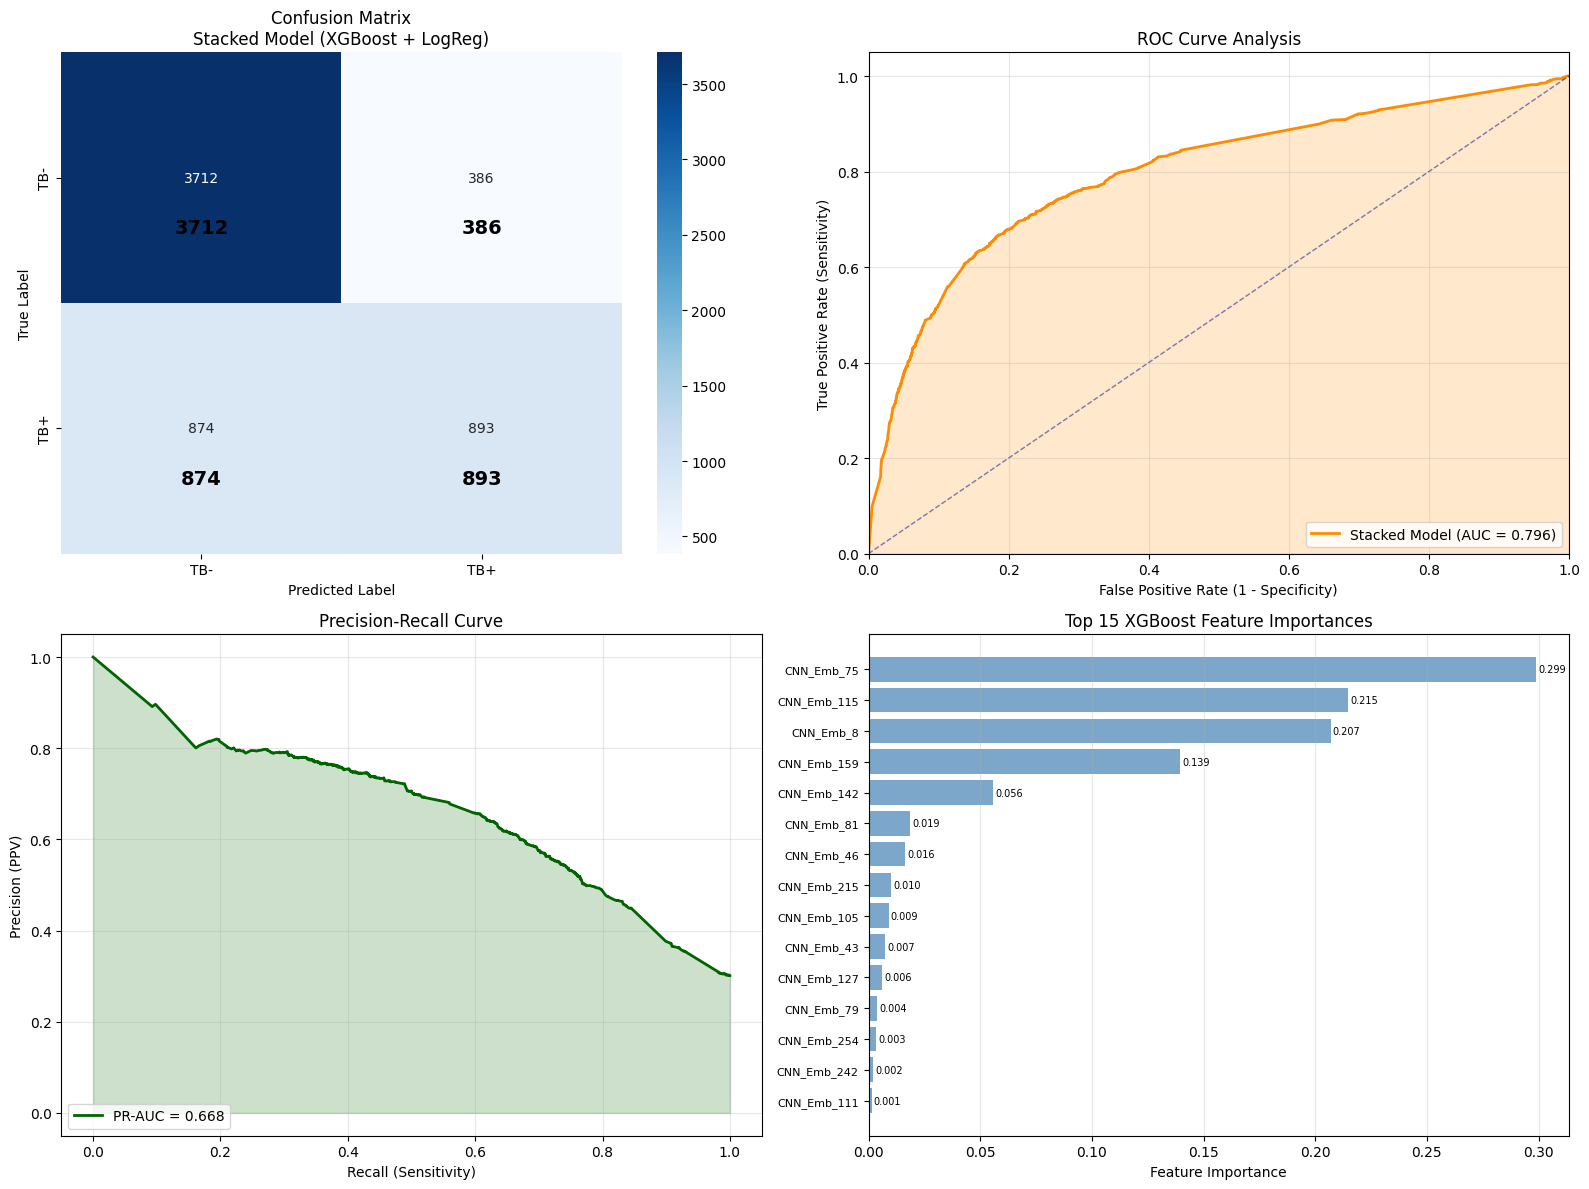


NOISE RESILIENCE ANALYSIS:
GAUSSIAN     | Samples: 1955 | Acc: 0.786 | Sens: 0.506 | Spec: 0.906 | AUC: 0.798
ENVIRONMENTAL | Samples: 1955 | Acc: 0.780 | Sens: 0.482 | Spec: 0.908 | AUC: 0.787
CLEAN        | Samples: 1955 | Acc: 0.790 | AUC: 0.804 (Baseline)

XGBoost Hyperparameters:
- learning_rate: 0.10174797407324213
- n_estimators: 644
- max_depth: 3
- subsample: 0.7168578594140873
- colsample_bytree: 0.8469926038510867
- reg_alpha: 0.058245828039608386
- reg_lambda: 0.34474115788895177
- scale_pos_weight: 2.836963163912251

Logistic Regression Stacker:
- Solver: liblinear
- Max iterations: 1000
- Regularization: L2 (C=0.01)
ACOUSTICTB EVALUATION COMPLETE - READY FOR PUBLICATION


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

print("="*80)
print("ACOUSTICTB: COMPREHENSIVE MODEL EVALUATION & ANALYSIS")
print("="*80)
y_pred = y_pred_stacked
y_proba = y_proba_stacked
print(f"\nTHRESHOLD OPTIMIZATION FOR TB SCREENING:")
print("="*50)
thresholds = np.arange(0.1, 0.9, 0.05)
for thresh in thresholds:
    y_pred_t = (y_proba >= thresh).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_val, y_pred_t).ravel()
    sens_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    spec_t = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    print(f"Senstivity {sens_t}, Specificity {spec_t} at threshold {thresh:.2f}")
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
npv = tn / (tn + fn)
ppv = tp / (tp + fp)

fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall_vals, precision_vals)

comp_score = composite(y_val, y_pred)

print(f"DATASET STATISTICS:")
print(f"Total samples: {len(y_val)} | TB+: {sum(y_val)} ({100*sum(y_val)/len(y_val):.1f}%) | TB-: {len(y_val)-sum(y_val)} ({100*(len(y_val)-sum(y_val))/len(y_val):.1f}%)")
print(f"Training patients: {len(train_patients)} | Validation patients: {len(val_patients)}")

print(f"\nCORE CLINICAL METRICS:")
print(f"Sensitivity (Recall): {sensitivity:.3f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}%)")
print(f"PPV (Precision): {precision:.3f} ({precision*100:.1f}%)")
print(f"NPV: {npv:.3f} ({npv*100:.1f}%)")
print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"F1-Score: {f1_score:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC: {pr_auc:.3f}")
print(f"Composite Score: {comp_score:.3f}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['TB-', 'TB+'], yticklabels=['TB-', 'TB+'])
ax1.set_title('Confusion Matrix\nStacked Model (XGBoost + LogReg)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        ax1.text(j+0.5, i+0.7, f'{cm[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacked Model (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
ax2.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate (1 - Specificity)')
ax2.set_ylabel('True Positive Rate (Sensitivity)')
ax2.set_title('ROC Curve Analysis')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

ax3.plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
ax3.fill_between(recall_vals, precision_vals, alpha=0.2, color='darkgreen')
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision (PPV)')
ax3.set_title('Precision-Recall Curve')
ax3.legend(loc="lower left")
ax3.grid(True, alpha=0.3)


importances = best_xgb.named_steps['clf'].feature_importances_
n_features = len(importances)
feature_names = [f'CNN_Emb_{i+1}' for i in range(256)] + ['Age', 'Height', 'Weight', 'Cough_Dur', 'HR', 'Temp', 'Sound_Score']

top_indices = np.argsort(importances)[-15:]
top_importances = importances[top_indices]
top_names = [feature_names[i] for i in top_indices]
    
bars = ax4.barh(range(len(top_importances)), top_importances, color='steelblue', alpha=0.7)
ax4.set_yticks(range(len(top_importances)))
ax4.set_yticklabels(top_names, fontsize=8)
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top 15 XGBoost Feature Importances')
ax4.grid(True, alpha=0.3, axis='x')
    
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=7)

plt.tight_layout()
plt.show()

print(f"\nNOISE RESILIENCE ANALYSIS:")
print("="*50)
noise_performance = {}
for noise_type in set(noise_types):
    if noise_type == 'clean':
        continue
    noise_mask = np.array([noise_types[i] for i in val_idx]) == noise_type
    if np.sum(noise_mask) > 5:
        noise_pred = y_pred[noise_mask]
        noise_true = y_val[noise_mask]
        noise_proba = y_proba[noise_mask]
        
        if len(set(noise_true)) > 1:
            noise_auc = roc_auc_score(noise_true, noise_proba)
            noise_acc = accuracy_score(noise_true, noise_pred)
            
            tn_n, fp_n, fn_n, tp_n = confusion_matrix(noise_true, noise_pred).ravel()
            noise_sens = tp_n / (tp_n + fn_n) if (tp_n + fn_n) > 0 else 0
            noise_spec = tn_n / (tn_n + fp_n) if (tn_n + fp_n) > 0 else 0
            
            noise_performance[noise_type] = {
                'samples': np.sum(noise_mask),
                'accuracy': noise_acc,
                'sensitivity': noise_sens,
                'specificity': noise_spec,
                'auc': noise_auc
            }

for noise, metrics in noise_performance.items():
    print(f"{noise.upper():12} | Samples: {metrics['samples']:3d} | "
          f"Acc: {metrics['accuracy']:.3f} | Sens: {metrics['sensitivity']:.3f} | "
          f"Spec: {metrics['specificity']:.3f} | AUC: {metrics['auc']:.3f}")

clean_mask = np.array([noise_types[i] for i in val_idx]) == 'clean'
if np.sum(clean_mask) > 0:
    clean_pred = y_pred[clean_mask]
    clean_true = y_val[clean_mask]
    clean_proba = y_proba[clean_mask]
    
    if len(set(clean_true)) > 1:
        clean_auc = roc_auc_score(clean_true, clean_proba)
        clean_acc = accuracy_score(clean_true, clean_pred)
        print(f"{'CLEAN':12} | Samples: {np.sum(clean_mask):3d} | ")
        print(f"Acc: {clean_acc:.3f} | AUC: {clean_auc:.3f} (Baseline)")


print(f"\nXGBoost Hyperparameters:")
if hasattr(best_xgb.named_steps['clf'], 'get_params'):
    xgb_params = best_xgb.named_steps['clf'].get_params()
    key_params = ['learning_rate', 'n_estimators', 'max_depth', 'subsample', 
                  'colsample_bytree', 'reg_alpha', 'reg_lambda', 'scale_pos_weight']
    for param in key_params:
        if param in xgb_params:
            print(f"- {param}: {xgb_params[param]}")

print(f"\nLogistic Regression Stacker:")
lr_params = stacker.get_params()
print(f"- Solver: {lr_params.get('solver', 'lbfgs')}")
print(f"- Max iterations: {lr_params.get('max_iter', 1000)}")
print(f"- Regularization: L2 (C={lr_params.get('C', 1.0)})")
